# Jaccard evaluations
In this notebook, we will evaluate the Jaccard similarity of the different methods. The first will be the implementation as provided from this Rust crate HyperLogLog couters, testing all of the available bits and precisions. Note that, since there are no Python bindings for the Rust crate (yet) we run the cose as one of the test in the crate test suite. 

The second one will be MinHash, using the implementation provided by the datasketch library. We will compare the performance of the two methods for the same amount of memory used.

## What is Jaccard similarity?
The Jaccard similarity is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the union of the two sets.

## What is an HyperLogLog counter?
An HyperLogLog counter is a probabilistic data structure used to estimate the cardinality of a set. It is based on the observation that the cardinality of a set can be estimated by the maximum number of leading zeros in the binary representation of the hashes of the elements of the set. The HyperLogLog counter is a data structure that stores the maximum number of leading zeros for a set of hashes. The counter is initialized with a number of bits, which determines the maximum number of leading zeros that can be stored. The counter is then updated with the hashes of the elements of the set. The estimate of the cardinality is then given by the harmonic mean of the values stored in the counter. HyperLogLog counters can be used to compute the cardinality of the union of two sets by taking the maximum of the values stored in the two counters, and therefore we can also compute the Jaccard similarity of two sets.

## What is MinHash?
MinHash is a probabilistic data structure used to estimate the Jaccard similarity of two sets. It is based on the observation that the Jaccard similarity of two sets can be estimated by the fraction of the elements of the two sets that have the same hash. The MinHash data structure is a list of hashes of the elements of the set. The hashes are computed by applying a hash function to each element of the set. The estimate of the Jaccard similarity is then given by the fraction of the elements of the two sets that have the same hash. MinHash can be used to compute the Jaccard similarity of the union of two sets by taking the minimum of the values stored in the two MinHash data structures.


We will use the version of MinHash available from [datasketch](https://github.com/ekzhu/datasketch), which is the one used as reference in the paper [Graph Neural Networks for Link Prediction with Subgraph Sketching](https://openreview.net/pdf?id=m1oqEOAozQU).

In [1]:
!pip install datasketch -q

We run the test suite, specifically make sure you run the test called test_jaccard_perfs, which will run the Jaccard similarity evaluation for all the available bits and precisions. The test will output a csv file with the results, which we will use to plot the results.

In [2]:
!cargo test --release

   Compiling hyperloglog-rs v0.1.38 (/home/luca/Github/hyperloglog-rs)
  --> tests/test_cardinalities.rs:22:4
   |
22 | fn splitmix64(mut x: u64) -> u64 {
   |    ^^^^^^^^^^
   |
   = note: `#[warn(dead_code)]` on by default

  --> tests/test_cardinalities.rs:29:4
   |
29 | fn xorshift(mut x: u64) -> u64 {
   |    ^^^^^^^^

  --> tests/test_cardinalities.rs:36:4
   |
36 | fn write_line<P: Precision + WordType<BITS>, const BITS: usize>(
   |    ^^^^^^^^^^

  --> tests/test_cardinalities.rs:57:4
   |
57 | fn test_cardinality_perfs() {
   |    ^^^^^^^^^^^^^^^^^^^^^^

    Finished release [optimized] target(s) in 24.54sjaccard_perfs(test)    
     Running unittests src/lib.rs (target/release/deps/hyperloglog_rs-f644f710901a4c54)

running 0 tests

test result: ok. 0 passed; 0 failed; 0 ignored; 0 measured; 0 filtered out; finished in 0.00s

     Running tests/test_cardinalities.rs (target/release/deps/test_cardinalities-6d5eb9a6b68fac38)

running 0 tests

test result: ok. 0 passed; 0 failed

and we load the results we have obtained:

In [3]:
import pandas as pd
df = pd.read_csv("jaccard_benchmark.tsv", sep="\t")
df["memory"] = 2**df.precision * df.bits
df

,precision,bits,exact,approximation,set1,set2,memory
0,4,1,0.451163,1.000000,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",16
1,4,2,0.451163,1.000000,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",32
2,4,3,0.451163,0.582010,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",48
3,4,4,0.451163,0.521435,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",64
4,4,5,0.451163,0.521435,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",80
...,...,...,...,...,...,...,...
8395,17,2,0.471412,0.469518,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",262144
8396,17,3,0.471412,0.469518,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",393216
8397,17,4,0.471412,0.469518,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",524288
8398,17,5,0.471412,0.469518,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",655360


We determine the number of u64 words to use for the MinHash to execute versions of MinHash with comparable memory usage to the HyperLogLog counters.

In [4]:
import math

bits = df.bits.unique()
precision = df.precision.unique()

number_of_words = {
    # We divide again by 2 because the number of permutations used is a u64
    # and by two again as 
    math.ceil(b * 2**p / 32) // 2 // 2
    for b in bits
    for p in precision
}

# Some HyperLogLog counters require less than 64 bits, so there will be
# values in the list that are zero. We remove them.
number_of_words = [
    word
    for word in number_of_words
    if word > 0
]

We parallelize the computation of the Jaccard similarity using MinHash, which is significantly slower than the HyperLogLog counters as while the former is an extensively optimized Rust implementation, the latter is more didactical Python implementation.

In [5]:
from typing import List
from datasketch import MinHash
from tqdm.auto import tqdm

def get_perfs(row) -> List:
    row = row[1]
    new_results = []
    set1 = [
        l.encode("utf8")
        for l in row.set1.split(",")
    ]
    set2 = [
        r.encode("utf8")
        for r in row.set2.split(",")
    ]
    for number_of_permutations in number_of_words:
        left_min_hash = MinHash(
            num_perm=number_of_permutations
        )
        right_min_hash = MinHash(
            num_perm=number_of_permutations
        )
        for left in set1:
            left_min_hash.update(left)
        for right in set2:
            right_min_hash.update(right)
        estimated = left_min_hash.jaccard(right_min_hash)
        new_results.append({
            "exact": row.exact,
            "set1": row.set1,
            "set2": row.set2,
            "approximation": estimated,
            "number_of_permutations": number_of_permutations
        })
    return new_results

We compute the performance of the two methods for the same amount of memory used.

In [6]:
from multiprocessing import Pool, cpu_count

with Pool(cpu_count()) as p:
    results = list(tqdm(
        p.imap(
            get_perfs,
            df.iterrows()
        ),
        total=df.shape[0]
    ))

  0%|          | 0/8400 [00:00<?, ?it/s]

We convert the results into a pandas DataFrame:

In [7]:
as_df = pd.DataFrame([
    r
    for result in tqdm(results)
    for r in result
])
as_df["memory"] = as_df.number_of_permutations * 64
as_df

  0%|          | 0/8400 [00:00<?, ?it/s]

,exact,set1,set2,approximation,number_of_permutations,memory
0,0.451163,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",0.000000,1,64
1,0.451163,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",0.500000,2,128
2,0.451163,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",0.468750,128,8192
3,0.451163,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",0.500000,4,256
4,0.451163,"939,732,531,709,58,829,313,638,564,392,232,533...","262,650,964,940,716,554,476,209,957,212,474,17...",0.464844,256,16384
...,...,...,...,...,...,...
302395,0.471412,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",0.465007,6144,393216
302396,0.471412,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",0.575000,80,5120
302397,0.471412,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",0.464453,2560,163840
302398,0.471412,"841,384,797,268,887,629,573,647,909,537,775,33...","153,878,830,311,443,43,227,496,460,32,765,874,...",0.531250,96,6144


In [8]:
as_df["squared_error"] = (as_df.exact - as_df.approximation)**2
data_minhash = as_df.groupby("memory")["squared_error"].agg(["mean", "std"]).reset_index()
data_minhash

,memory,mean,std
0,64,0.245700,0.038829
1,128,0.111834,0.119985
2,192,0.066232,0.082245
3,256,0.044520,0.058441
4,320,0.036147,0.044544
5,384,0.029469,0.043035
6,512,0.026213,0.042820
7,640,0.020692,0.030710
8,768,0.016957,0.021557
9,1024,0.014456,0.024049


In [9]:
df["squared_error"] = (df.exact - df.approximation)**2
data_hll = df.groupby(["precision", "bits", "memory"])["squared_error"].agg(["mean", "std"])
data_hll = data_hll.reset_index()
data_hll

,precision,bits,memory,mean,std
0,4,1,16,0.288176,0.016250
1,4,2,32,0.288176,0.016250
2,4,3,48,0.026676,0.028074
3,4,4,64,0.030784,0.032352
4,4,5,80,0.030784,0.032352
...,...,...,...,...,...
79,17,2,262144,0.000001,0.000001
80,17,3,393216,0.000001,0.000001
81,17,4,524288,0.000001,0.000001
82,17,5,655360,0.000001,0.000001


We visualize two versions of the HyperLogLog counters, one including also **EXTREMELY SMALL** registers of 1 and 2 bits, which really push the limits of the HyperLogLog counters, and one without them, which is more representative of the performance of the HyperLogLog counters for the more common use cases. We include these tiny registers as exploring the limits of the HyperLogLog counters is one of the main goals of this project.

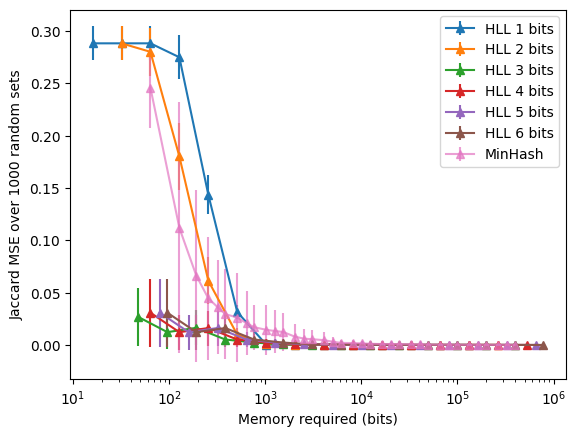

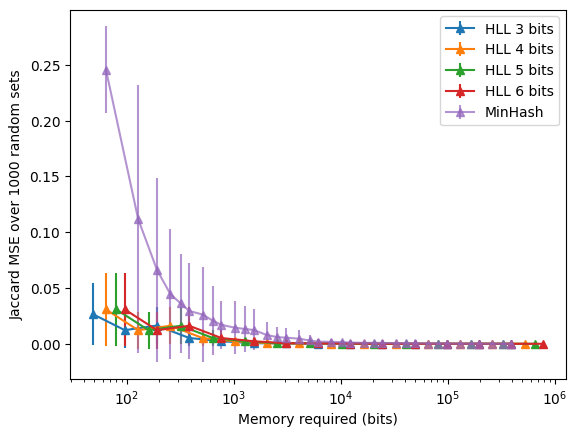

In [12]:
import matplotlib.pyplot as plt

for bits_to_discard in ((), (1, 2)):
    for bits in data_hll["bits"].unique():
        if bits in bits_to_discard:
            continue
        filtered = data_hll[data_hll.bits == bits]
        plt.errorbar(
            filtered.memory,
            filtered["mean"],
            filtered["std"],
            marker='^',
            label=f"HLL {bits} bits"
        )
    plt.errorbar(
        data_minhash.memory,
        data_minhash["mean"],
        data_minhash["std"],
        marker='^',
        label="MinHash",
        alpha=0.7
    )
    plt.legend()
    plt.xscale("log")
    #plt.yscale("log")
    plt.ylabel("Jaccard MSE over 1000 random sets")
    plt.xlabel("Memory required (bits)")
    plt.show()

We do the same thing, but we multiply the error by the number of bits necessary by the data structure, so to better understand how the error scales with the number of bits used.

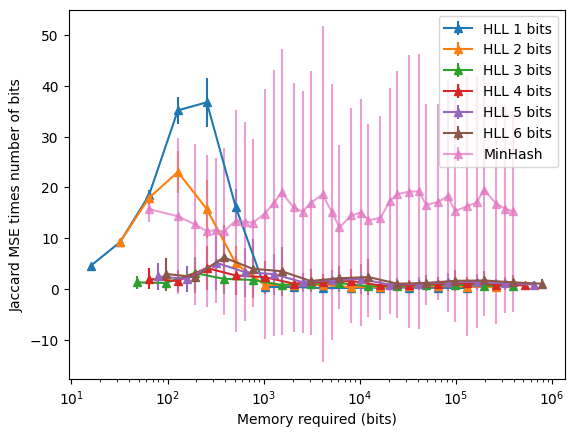

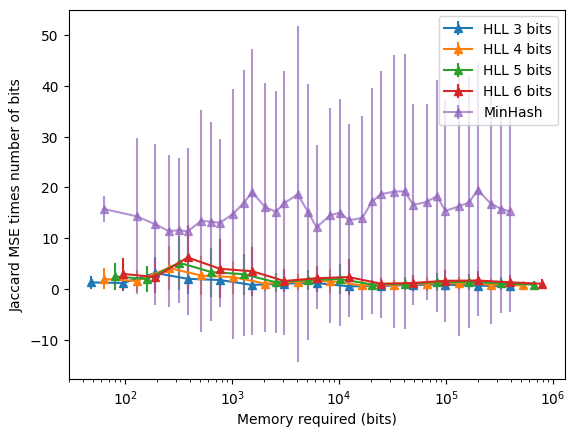

In [13]:
import matplotlib.pyplot as plt


for bits_to_discard in ((), (1, 2)):
    for bits in data_hll["bits"].unique():
        if bits in bits_to_discard:
            continue
        filtered = data_hll[data_hll.bits == bits]
        plt.errorbar(
            filtered.memory,
            filtered["mean"] * filtered.memory,
            filtered["std"] * filtered.memory,
            marker='^',
            label=f"HLL {bits} bits"
        )

    plt.errorbar(
        data_minhash.memory,
        data_minhash["mean"] * data_minhash.memory,
        data_minhash["std"] * data_minhash.memory,
        marker='^',
        label="MinHash",
        alpha=0.7
    )
    plt.legend()
    plt.xscale("log")
    plt.ylabel("Jaccard MSE times number of bits")
    plt.xlabel("Memory required (bits)")
    plt.show()